<a href="https://colab.research.google.com/github/taliafabs/sta496/blob/main/VoteChoice_RaceDep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Logistic Regression Vote Choice Models Using Recent U.S. Presidential Election Data




In [ ]:
# Workplace setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pymc as pm
import random
from scipy import stats
from scipy.stats.distributions import chi2

## Data

The datasets used for this project are the 2020 and 2024 CES survey datasets, obtained from Harvard Dataverse. They can be found at the following links:
* 2024: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/X11EP6
* 2020: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/E9N6PH

#### Loading the data

In [ ]:
# loading the data
from google.colab import drive
drive.mount('/content/drive')

# 2024
ces24 = pd.read_stata("/content/drive/MyDrive/STA496/Datasets/CES24_Common.dta")

# 2020
ces20 = pd.read_stata("/content/drive/MyDrive/STA496/Datasets/CES20_Common_OUTPUT_vv.dta")

Mounted at /content/drive


In [ ]:
# 2016
ces16 = pd.read_stata("/content/drive/MyDrive/STA496/Datasets/CCES16_Common_OUTPUT_Feb2018_VV.dta")

#### Preparing/cleaning the data

In [ ]:
# data preparation
ces24_subset = ces24[['gender4', 'race', 'hispanic', 'educ', 'marstat', 'inputstate', 'region', 'birthyr',
                  'ownhome', 'urbancity', 'industry',
                  'religpew', 'pew_religimp', 'pew_churatd', 'pew_prayer',
                  'CC24_361b', 'CC24_363', 'CC24_364a', 'CC24_364b', 'presvote20post', 'pid3', 'pid7'
                  ]]

ces20_subset = ces20[['gender', 'race', 'hispanic', 'educ', 'marstat', 'inputstate', 'region', 'birthyr',
                      'ownhome', 'urbancity', 'industryclass',
                      'religpew', 'pew_religimp', 'pew_churatd', 'pew_prayer',
                      'votereg', 'votereg_f','CC20_364a', 'CC20_364b', 'presvote16post', 'pid3', 'pid7']]

# only include trump and biden/harris
ces24_subset = ces24_subset[
    (ces24_subset['CC24_364a'] == "Kamala Harris (Democrat)") |
    (ces24_subset['CC24_364a'] == "Donald Trump (Republican)")
]

ces20_subset = ces20_subset[
    (ces20_subset['CC20_364a'] == "Joe Biden (Democrat)") |
    (ces20_subset['CC20_364a'] == "Donald Trump (Republican)")
]

# create vote_trump binary variable
ces24_subset['vote_trump'] = np.where(ces24_subset['CC24_364a'] == 'Donald Trump (Republican)', 1, 0)
ces20_subset['vote_trump'] = np.where(ces20_subset['CC20_364a'] == 'Donald Trump (Republican)', 1, 0)

# columns
ces24_subset['age'] = 2024 - ces24_subset['birthyr']

ces24_subset['age_bracket'] = pd.cut(
    ces24_subset['age'],
    bins=[17, 24, 34, 44, 54, 64, 74, 100],
    labels=[
        '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+'
    ]
)

ces24_subset = ces24_subset[[
    'vote_trump',
    'age_bracket',
    'gender4',
    'race',
    'educ',
    'region',
    'urbancity',
    'religpew',
    'pid3'
]]

# 2020
ces20_subset['age'] = 2020 - ces20_subset['birthyr']

ces20_subset['age_bracket'] = pd.cut(
    ces20_subset['age'],
    bins=[17, 24, 34, 44, 54, 64, 74, 100],
    labels=[
        '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+'
    ]
)

ces20_subset = ces20_subset[[
    'vote_trump',
    'age_bracket',
    'gender',
    'race',
    'educ',
    'region',
    'urbancity',
    'religpew',
    'pid3'
]]

# categorical predictors
predictors24 = ces24_subset.columns.drop('vote_trump')
ces24_subset[predictors24] = ces24_subset[predictors24].astype('category')
predictors20 = ces20_subset.columns.drop('vote_trump')
ces20_subset[predictors20] = ces20_subset[predictors20].astype('category')

ces24_subset.dropna(inplace=True)
ces20_subset.dropna(inplace=True)

# dropping race
ces24_subset_no_race = ces24_subset.drop(columns=['race'])
ces20_subset_no_race = ces20_subset.drop(columns=['race'])

In [ ]:
# Dummy variables and interaction terms

race_dummies_24 = pd.get_dummies(ces24_subset['race'], prefix='race', drop_first=True)
gender_dummies_24 = pd.get_dummies(ces24_subset['gender4'], prefix='gender', drop_first=True)
education_dummies_24 = pd.get_dummies(ces24_subset['educ'], prefix='educ', drop_first=True)
region_dummies_24 = pd.get_dummies(ces24_subset['region'], prefix='region', drop_first=True)

race_dummies_20 = pd.get_dummies(ces20_subset['race'], prefix='race', drop_first=True)
gender_dummies_20 = pd.get_dummies(ces20_subset['gender'], prefix='gender', drop_first=True)
education_dummies_20 = pd.get_dummies(ces20_subset['educ'], prefix='educ', drop_first=True)
region_dummies_20 = pd.get_dummies(ces20_subset['region'], prefix='region', drop_first=True)

ces24_subset_full = pd.get_dummies(ces24_subset, drop_first=True)
ces20_subset_full = pd.get_dummies(ces20_subset, drop_first=True)

race_gender_interaction_terms_24 = pd.DataFrame()
race_gender_interaction_terms_20 = pd.DataFrame()

race_educ_interaction_terms_24 = pd.DataFrame()
race_educ_interaction_terms_20 = pd.DataFrame()

race_urban_interaction_terms_24 = pd.DataFrame()
race_urban_interaction_terms_20 = pd.DataFrame()

race_region_interaction_terms_20 = pd.DataFrame()
race_region_interaction_terms_24 = pd.DataFrame()

# race x gender
for col1 in race_dummies_24.columns: # go thru every race dummy
    for col2 in gender_dummies_24.columns: # race * gender
        race_gender_interaction_terms_24[f'{col1}_{col2}'] = race_dummies_24[col1] * gender_dummies_24[col2]

for col1 in race_dummies_20.columns: # go thru every race dummy
    for col2 in gender_dummies_20.columns: # race * gender
        race_gender_interaction_terms_20[f'{col1}_{col2}'] = race_dummies_20[col1] * gender_dummies_20[col2]

# race x education
for race_col in race_dummies_24.columns:
    for educ_col in education_dummies_24.columns:
        race_educ_interaction_terms_24[f'{race_col}_{educ_col}'] = race_dummies_24[race_col] * education_dummies_24[educ_col]

for race_col in race_dummies_20.columns:
    for educ_col in education_dummies_20.columns:
        race_educ_interaction_terms_20[f'{race_col}_{educ_col}'] = race_dummies_20[race_col] * education_dummies_20[educ_col]

# race x region
for race_col in race_dummies_24.columns:
    for region_col in region_dummies_24.columns:
        race_region_interaction_terms_24[f'{race_col}_{region_col}'] = race_dummies_24[race_col] * region_dummies_24[region_col]

for race_col in race_dummies_20.columns:
    for region_col in region_dummies_20.columns:
        race_region_interaction_terms_20[f'{race_col}_{region_col}'] = race_dummies_20[race_col] * region_dummies_20[region_col]

# race x urban
for race_col in race_dummies_24.columns:
    for urban_col in race_dummies_24.columns:
        race_urban_interaction_terms_24[f'{race_col}_{urban_col}'] = race_dummies_24[race_col] * race_dummies_24[urban_col]

for race_col in race_dummies_20.columns:
    for urban_col in race_dummies_20.columns:
        race_urban_interaction_terms_20[f'{race_col}_{urban_col}'] = race_dummies_20[race_col] * race_dummies_20[urban_col]

## Frequentist Approach

Frequentist approach; simplified without interaction terms due to computational and dataset limitations as of now.

This approach examines whether we can outright remove race from the vote choice classification models for 2020 and  2024.

### Models

Likelihood ratio test and frequentist model evals
Is the race main effect significant?
How did the significance of race change between 2020 and 2024?

Likelihood ratio test will compare nested logistic GLMs to determine whether the more complex model provides a significantly better explanation of the data than the simpler model.
\
Model 0 (full model, includes race main effect and race x region interaction):

\begin{align*}
p(\text{vote_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{race}
  + \beta_2 \cdot \text{gender}
  + \beta_3 \cdot \text{educ}
  + \beta_4 \cdot \text{age_bracket}
  + \beta_5 \cdot \text{region}
  + \beta_6 \cdot \text{urbancity}
  + \beta_7 \cdot \text{religion}
  + \beta_8 \cdot \text{party_id}
  + \beta_9 \cdot (\text{race} \times \text{region})
\big)
\end{align*}

Model 1: (reduced model, drops race x region interaction):
\begin{align*}
p(\text{vote_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{race}
  + \beta_2 \cdot \text{gender}
  + \beta_3 \cdot \text{educ}
  + \beta_4 \cdot \text{age_bracket}
  + \beta_5 \cdot \text{region}
  + \beta_6 \cdot \text{urbancity}
  + \beta_7 \cdot \text{religion}
  + \beta_8 \cdot \text{party_id}
\big)
\end{align*}
Model 2: (reduced model, drops all race-related predictors)
\begin{align*}
p(\text{vote_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{gender}
  + \beta_2 \cdot \text{educ}
  + \beta_3 \cdot \text{age_bracket}
  + \beta_4 \cdot \text{region}
  + \beta_5 \cdot \text{urbancity}
  + \beta_6 \cdot \text{religion}
  + \beta_7 \cdot \text{party_id}
\big)
\end{align*}

#### 2024

In [ ]:
# model 0: include race main and race x region interaction
ces24_model0 = smf.logit("vote_trump ~ C(race) + C(gender4) + C(educ) + C(age_bracket) + C(region) + C(urbancity) \
                         + C(religpew) + C(pid3) + C(race):C(region)",
                         data=ces24_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.224373
         Iterations 9


In [ ]:
# model 1: 2024 remove inteaction only
ces24_model1 = smf.logit("vote_trump ~ C(race) + C(gender4) + C(educ) + C(age_bracket) + C(region) \
+ C(urbancity) + C(religpew) + C(pid3)",
                         data=ces24_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.226922
         Iterations 9


In [ ]:
# model 2: remove race from the model entirely
ces24_model2 = smf.logit("vote_trump ~  C(gender4) + C(educ) + C(age_bracket) + C(region) \
+ C(urbancity) + C(religpew) + C(pid3)",
                         data=ces24_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.228995
         Iterations 9


#### 2020

In [ ]:
ces20_model0 = smf.logit("vote_trump ~ C(race) + C(gender) + C(educ) + C(age_bracket) + C(region) + C(urbancity) + C(religpew) + C(pid3) + C(race):C(region)",
                         data=ces20_subset).fit(maxiter=100000)

         Current function value: inf
         Iterations: 100000


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# 2020 include race as main effect; remove all interactions
ces20_model1 = smf.logit("vote_trump ~ C(race) + C(gender) + C(educ) + C(age_bracket) + C(region) + C(urbancity) + C(religpew) + C(pid3)",
                         data=ces20_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.231126
         Iterations 9


In [ ]:
# 2020 remove race from model entirely
ces20_model2 = smf.logit("vote_trump ~  C(gender) + C(educ) + C(age_bracket) + C(region) + C(urbancity) + C(religpew) + C(pid3)",
                         data=ces20_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.235632
         Iterations 8


### Results

In [ ]:
print(ces24_model0.summary())

                           Logit Regression Results                           
Dep. Variable:             vote_trump   No. Observations:                 9246
Model:                          Logit   Df Residuals:                     9181
Method:                           MLE   Df Model:                           64
Date:                Sun, 29 Jun 2025   Pseudo R-squ.:                  0.6372
Time:                        19:56:31   Log-Likelihood:                -2074.5
converged:                       True   LL-Null:                       -5717.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -3.9114      0.423     -9.254      0.000      -4.740      -3.083
C(race)[T.Blac

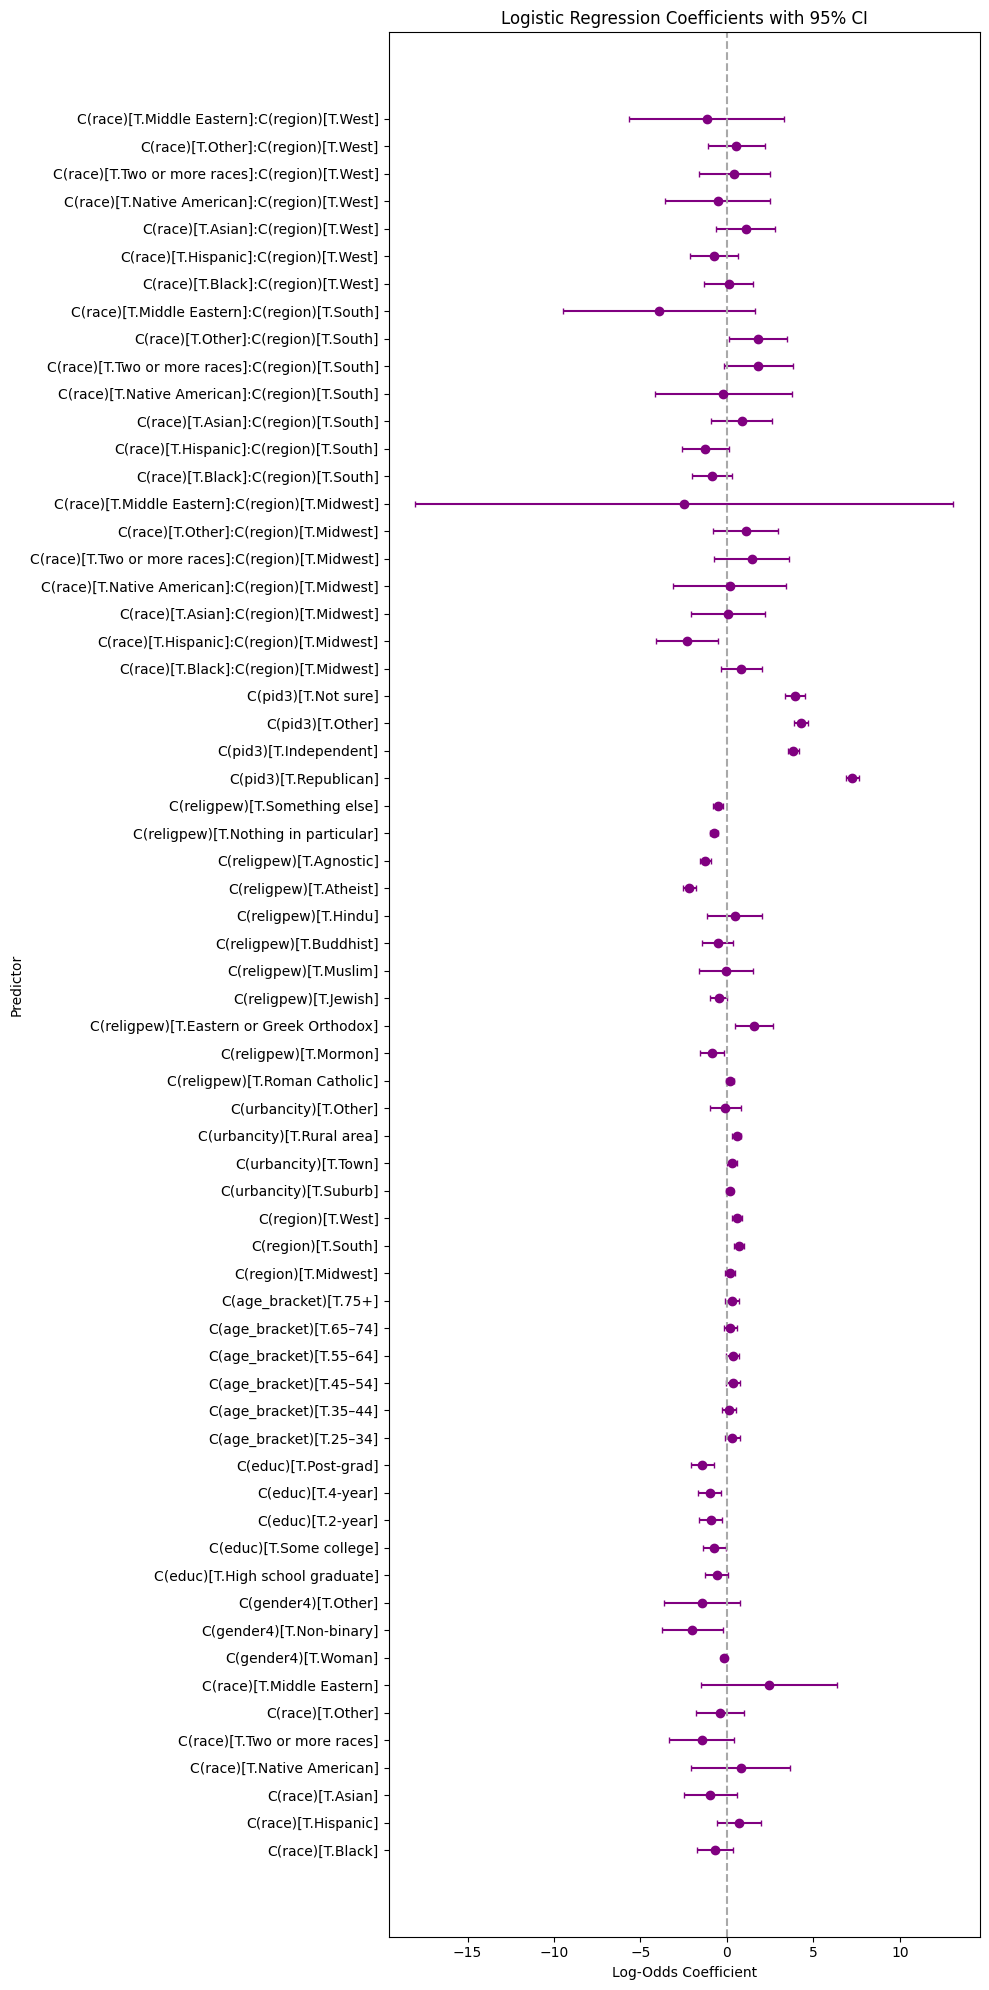

In [ ]:
# i used chat gpt to make this visualization
# Get summary frame from the model
summary_frame = ces24_model0.summary2().tables[1]  # use summary2 for easier access
summary_frame = summary_frame.reset_index().rename(columns={'index': 'term'})

# Remove intercept if you don't want it
# summary_frame = summary_frame[summary_frame['term'] != 'Intercept']

# Extract variables
terms = summary_frame['term']
coefs = summary_frame['Coef.']
lower = summary_frame['[0.025']
upper = summary_frame['0.975]']

# Compute error bars
yerr = [coefs - lower, upper - coefs]

# Plot
plt.figure(figsize=(10, 20))
plt.errorbar(coefs, terms, xerr=yerr, fmt='o', color='purple', ecolor='purple', capsize=2)
plt.axvline(x=0, color='darkgray', linestyle='--')
plt.title('Logistic Regression Coefficients with 95% CI')
plt.xlabel('Log-Odds Coefficient')
plt.ylabel('Predictor')
plt.tight_layout()
plt.show()

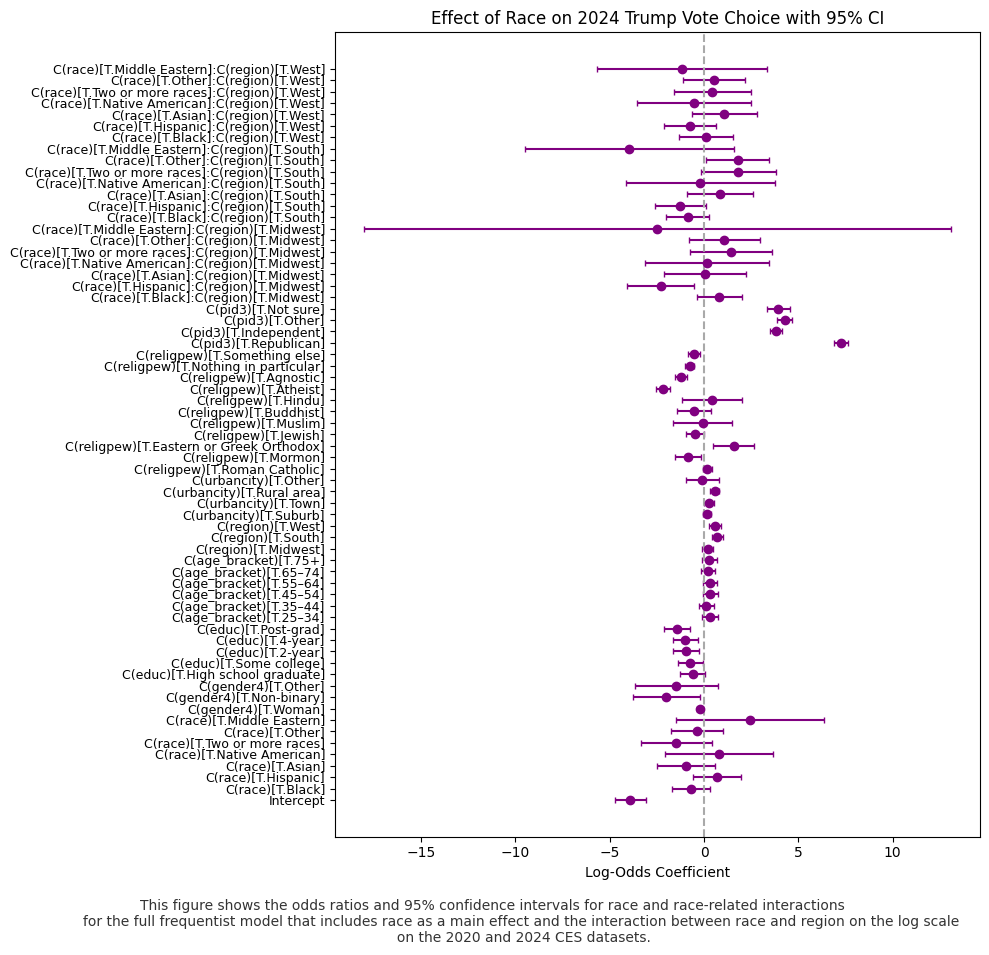

In [ ]:
# 2024

summary_frame = ces24_model0.summary2().tables[1]  # use summary2 for easier access
summary_frame = summary_frame.reset_index().rename(columns={'index': 'term'})

# Remove intercept if you don't want it
# summary_frame = summary_frame[summary_frame['term'] != 'Intercept']
# summary_frame = summary_frame[
#     summary_frame['term'].str.startswith('C(race)')
# ]

# Extract variables
terms = summary_frame['term']
coefs = summary_frame['Coef.']
lower = summary_frame['[0.025']
upper = summary_frame['0.975]']

# Compute error bars
yerr = [coefs - lower, upper - coefs]

# Plot
plt.figure(figsize=(10, 9))
plt.yticks(fontsize=9)
plt.errorbar(coefs, terms, xerr=yerr, fmt='o', color='purple', ecolor='purple', capsize=2)
plt.axvline(x=0, color='darkgray', linestyle='--')
plt.title('Effect of Race on 2024 Trump Vote Choice with 95% CI')
plt.xlabel('Log-Odds Coefficient')
plt.ylabel('')
plt.figtext(0.5, -0.05,
            'This figure shows the odds ratios and 95% confidence intervals for race and race-related interactions \n \
            for the full frequentist model that includes race as a main effect and the interaction between race and region on the log scale \n \
            on the 2020 and 2024 CES datasets.',
            wrap=True,
            horizontalalignment='center',
            fontsize=10,
            color="#333333")
plt.tight_layout()
plt.show()

In [ ]:
print(ces20_model0.summary())

                           Logit Regression Results                           
Dep. Variable:             vote_trump   No. Observations:                11444
Model:                          Logit   Df Residuals:                    11381
Method:                           MLE   Df Model:                           62
Date:                Sun, 29 Jun 2025   Pseudo R-squ.:                    -inf
Time:                        19:56:33   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                       -6016.4
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -3.7466      0.339    -11.038      0.000      -4.412      -3.081
C(race)[T.Blac

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


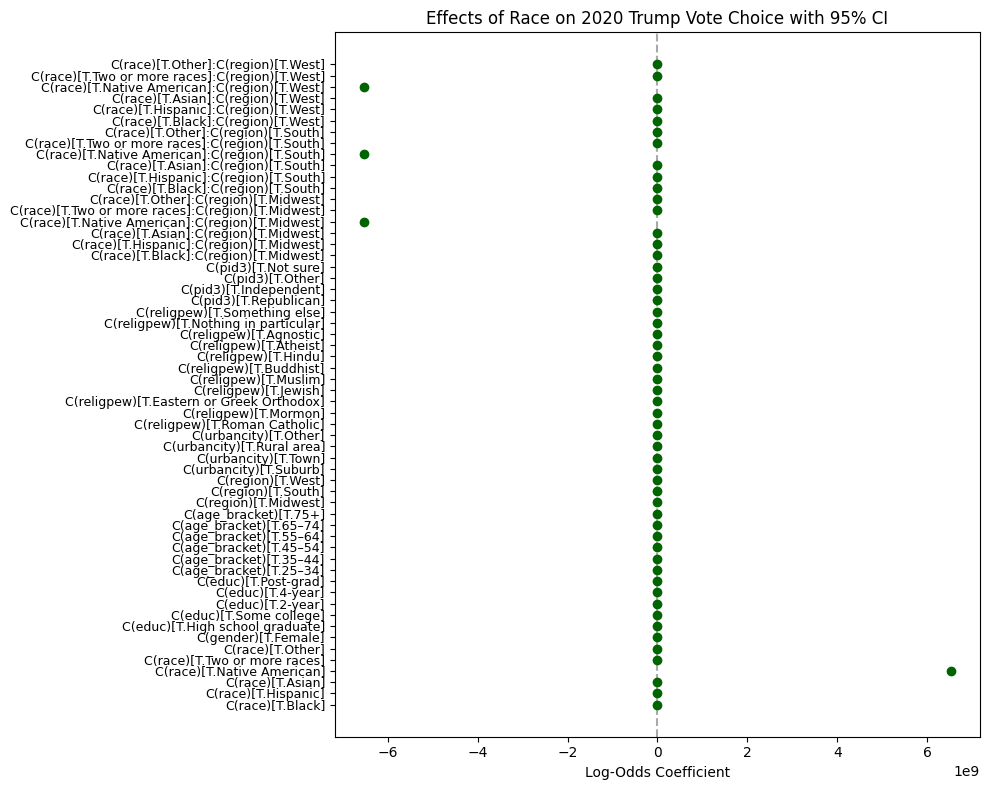

In [ ]:
# i used chat gpt to make this visualization
# Get summary frame from the model
summary_frame = ces20_model0.summary2().tables[1]  # use summary2 for easier access
summary_frame = summary_frame.reset_index().rename(columns={'index': 'term'})

# Remove intercept if you don't want it
summary_frame = summary_frame[summary_frame['term'] != 'Intercept']

# race_terms = summary_frame[summary_frame['term'].str.startswith('C(race)')]
summary_frame = summary_frame[
    # summary_frame['term'].str.startswith('C(race)') &
    # ~summary_frame['term'].str.contains('Native American', regex=True) &
    ~summary_frame['term'].str.contains('Middle Eastern', regex=True)
]


# Extract variables
terms = summary_frame['term']
coefs = summary_frame['Coef.']
lower = summary_frame['[0.025']
upper = summary_frame['0.975]']

# Compute error bars
yerr = [coefs - lower, upper - coefs]

# Plot
plt.figure(figsize=(10, 8))
plt.yticks(fontsize=9)
plt.errorbar(coefs, terms, xerr=yerr, fmt='o', color='darkgreen', ecolor='darkgreen', capsize=2)
plt.axvline(x=0, color='darkgray', linestyle='--')
plt.title('Effects of Race on 2020 Trump Vote Choice with 95% CI')
plt.xlabel('Log-Odds Coefficient')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 2020 ---
summary_2020 = ces20_model0.summary2().tables[1].reset_index().rename(columns={'index': 'term'})
summary_2020 = summary_2020[
    ~summary_2020['term'].str.contains('Native American', regex=True) &
    ~summary_2020['term'].str.contains('Middle Eastern', regex=True)
]

# --- 2024 ---
summary_2024 = ces24_model0.summary2().tables[1].reset_index().rename(columns={'index': 'term'})
summary_2024 = summary_2024[
    ~summary_2024['term'].str.contains('Native American', regex=True) &
    ~summary_2024['term'].str.contains('Middle Eastern', regex=True)
]

# --- Clean terms and align both ---
summary_2020['year'] = '2020'
summary_2024['year'] = '2024'
combined = pd.concat([summary_2020, summary_2024])

# Clean race labels
combined['race'] = combined['term'].str.extract(r'C\(race\)\[T\.(.*)\]')
combined['race'] = combined['race'].str.replace('_', ' ')  # optional: cleaner labels

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 9))

for year, color in zip(['2020', '2024'], ['darkgreen', 'purple']):
    data = combined[combined['year'] == year]
    coefs = data['Coef.']
    lower = data['[0.025']
    upper = data['0.975]']
    yerr = [coefs - lower, upper - coefs]
    ax.errorbar(
        coefs, data['race'], xerr=yerr, fmt='o',
        label=year, color=color, ecolor=color, capsize=3
    )

ax.axvline(x=0, color='#555555', linestyle='--')
ax.set_xlabel('Log-Odds Coefficient', fontsize=10)
ax.set_ylabel('Race Group (vs. White)', fontsize=10)
ax.set_yticks(sorted(combined['race'].unique()))  # ensure order
ax.tick_params(axis='y', labelsize=9)
ax.set_title('Effects of Race on Trump Vote Choice (2020 vs. 2024)', fontsize=12)
ax.legend(title='CES Year')
plt.figtext(0.5, -0.03,
            'Note: Coefficients represent estimated log-odds of voting for Trump relative to White respondents.\nError bars show 95% confidence intervals. Source: CES 2020 & 2024 data.',
            wrap=True, horizontalalignment='center', fontsize=9, color="#333333")
plt.tight_layout()
plt.show()


***Likelihood ratio tests***

In [ ]:
from scipy.stats.distributions import chi2

def likelihood_ratio(full_model, reduced_model):
  """
  Calculates likelihood ratio test statistic for comparing two nested
  generalized linear models (GLMs).

  Parameters
    - full_model: the full (more complex) model
    - reduced_model: the reduced (simpler) model where its parameters are a
    subset of those in full_model

  Returns
    - likelihood ratio test statistic (float)
    - difference in degrees of freedom between full and reduced models (int)
    - p-value for the likelihood ratio test (float)
  """
  lr_stat = 2*(full_model.llf - reduced_model.llf)
  df_diff = int(full_model.df_model - reduced_model.df_model)
  p_value = 1 - chi2.cdf(lr_stat, df_diff)
  return(f'LR stat: {lr_stat:.4f}, full df - reduced df: {df_diff}, p-value: {p_value}')

**2024**

In [ ]:
# model 0 vs model 1
print(likelihood_ratio(ces24_model0, ces24_model1))

LR stat: 47.1416, full df - reduced df: 21, p-value: 0.0008987791605244988


In [ ]:
# model 1 vs model 2
print(likelihood_ratio(ces24_model1, ces24_model2))

LR stat: 38.3388, full df - reduced df: 7, p-value: 2.6123141803058303e-06


In [ ]:
# model 0 vs model 2
print(likelihood_ratio(ces24_model0, ces24_model2))

LR stat: 85.4804, full df - reduced df: 28, p-value: 9.91846926812201e-08


**2020**

In [ ]:
# model 0 vs model 1 (is the interaction significant?)
print(likelihood_ratio(ces20_model0, ces20_model1))


NameError: name 'likelihood_ratio' is not defined

suggests that race x region interaction gained significance in 2024
connect to kuriwaki paper

In [ ]:
# model 1 vs model 2 (is the main effect significant?)
print(likelihood_ratio(ces20_model1, ces20_model2))
# p value is basically 0, so yes

LR stat: 103.1341, full df - reduced df: 7, p-value: 0.0


In [ ]:
# how much better does adding in race and race x region make model
print(likelihood_ratio(ces20_model0, ces20_model2))

LR stat: -inf, full df - reduced df: 28, p-value: 1.0


## Machine Learning (ML) Approach

### Models

I will evaluate the performance of the following logistic regression models on the CES 2020 and 2024 datasets:

**Full model (model 0)**
Adds in geographic interaction terms as suggested by Kuriwaki et al.
does this more complex model improve performance?
$$
p(\text{vote_trump} = 1) = \sigma \Bigg(
\beta_0
+ \beta_1 \cdot \text{age_bracket}
+ \beta_2 \cdot \text{gender}
+ \beta_3 \cdot \text{race}
+ \beta_4 \cdot \text{educ}
+ \beta_5 \cdot \text{region}
+ \beta_6 \cdot \text{urbancity}
+ \beta_7 \cdot \text{religpew}
+ \beta_8 \cdot \text{pid3}
+ \beta_9 \cdot (\text{race} \times \text{gender})
+ \beta_{10} \cdot (\text{race} \times \text{educ})
+ \beta_{11} \cdot (\text{race} \times \text{region})
+ \beta_{12} \cdot (\text{race} \times \text{rural_urban})
\Bigg)
$$


where:
$$\sigma(z) = \frac{1}{1+e^z}$$
\
$$
z = \beta_0
+ \beta_1 \cdot \text{age_bracket}
+ \beta_2 \cdot \text{gender}
+ \beta_3 \cdot \text{race}
+ \beta_4 \cdot \text{educ}
+ \beta_5 \cdot \text{region}
+ \beta_6 \cdot \text{urbancity}
+ \beta_7 \cdot \text{religpew}
+ \beta_8 \cdot \text{pid3}
+ \beta_9 \cdot (\text{race} \times \text{gender})
+ \beta_{10} \cdot (\text{race} \times \text{educ})
+ \beta_{11} \cdot (\text{race} \times \text{region})
+ \beta_{12} \cdot (\text{race} \times \text{rural_urban})
$$

In [ ]:
# full model
# combine data frames for full ML models
# do not drop main effects
df_24_full_model = pd.concat([
    ces24_subset_full, # main effect dummies
    race_gender_interaction_terms_24,
    race_educ_interaction_terms_24,
    race_region_interaction_terms_24,
    race_urban_interaction_terms_24
], axis=1)

df_20_full_model = pd.concat([
    ces20_subset_full,
    race_gender_interaction_terms_20,
    race_educ_interaction_terms_20,
    race_region_interaction_terms_20,
    race_urban_interaction_terms_20
], axis=1)

# does include desired columns

**Model B: remove race main effect**

In [ ]:
# model b
# combine data frames for model with no race main but race interactions
# steps: drop the race column, get the dummies, add in the interaction dummies
df_24_modelb = pd.concat([
    # ces24_subset_full, # main effect dummies
    pd.get_dummies(ces24_subset.drop(columns='race')),
    race_educ_interaction_terms_24,
    race_gender_interaction_terms_24,
    race_region_interaction_terms_24,
    race_urban_interaction_terms_24
], axis=1)

df_20_modelb = pd.concat([
    pd.get_dummies(ces20_subset.drop(columns='race')),  # remove race as main effect
    race_gender_interaction_terms_20, # still keep gender educationinteractions
    race_educ_interaction_terms_20,
    race_region_interaction_terms_20,
    race_urban_interaction_terms_20
], axis=1)

**Model C: Remove geographic interaction terms**
$$
p(\text{vote_trump} = 1) = \sigma \Bigg(
\beta_0
+ \beta_1 \cdot \text{age_bracket}
+ \beta_2 \cdot \text{gender}
+ \beta_3 \cdot \text{race}
+ \beta_4 \cdot \text{educ}
+ \beta_5 \cdot \text{region}
+ \beta_6 \cdot \text{urbancity}
+ \beta_7 \cdot \text{religpew}
+ \beta_8 \cdot \text{pid3}
+ \beta_9 \cdot (\text{race} \times \text{gender})
+ \beta_{10} \cdot (\text{race} \times \text{educ})
\Bigg)
$$

In [ ]:
df_24_modelc = pd.concat([
    ces24_subset_full, # main effect dummies
    race_gender_interaction_terms_24,
    race_educ_interaction_terms_24,
    # race_region_interaction_terms_24,# remove
    # race_urban_interaction_terms_24
], axis=1)

df_20_modelc = pd.concat([
    ces20_subset_full,
    race_gender_interaction_terms_20,
    race_educ_interaction_terms_20,
    # race_region_interaction_terms_20,
    # race_urban_interaction_terms_20
], axis=1)


**Model D: Remove race x gender and race x education**

In [ ]:
# identical to model 0 in the frequentist section
df_24_modeld = pd.concat([
    ces24_subset_full, # main effect dummies
    # race_gender_interaction_terms_24,
    # race_educ_interaction_terms_24,
    race_region_interaction_terms_24,
    race_urban_interaction_terms_24
], axis=1)

df_20_modeld = pd.concat([
    ces20_subset_full,
    # race_gender_interaction_terms_20,
    # race_educ_interaction_terms_20,
    race_region_interaction_terms_20,
    race_urban_interaction_terms_20
], axis=1)

**Model E: remove all race-related**

In [ ]:
# model e remove race educ
df_24_modele = pd.get_dummies(ces24_subset.drop(columns='race'))
# df_24_modele = pd.concat([
#     ces24_subset_full, # main effect dummies
#     # race_gender_interaction_terms_24,
#     # race_educ_interaction_terms_24,
#     # race_region_interaction_terms_24,
#     # race_urban_interaction_terms_24
# ], axis=1)

df_20_modele = pd.concat([
    ces20_subset_full,
    # race_gender_interaction_terms_20,
    # race_educ_interaction_terms_20,
    # race_region_interaction_terms_20,
    # race_urban_interaction_terms_20
], axis=1)


In [ ]:
# model 5: no race at all (no main effect, no interactions)
# df_24_no_race = pd.get_dummies(ces24_subset.drop(columns='race'))
# df_20_no_race = pd.get_dummies(ces20_subset.drop(columns='race'))

Reduced model: remove race x education

##### 2024

In [ ]:
# model a: full
X_24 = df_24_full_model.drop(columns=['vote_trump'])
y_24 = df_24_full_model['vote_trump']

# train test split
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24,
                                                                random_state=random.randint(1, 10000))
# train
model0_ml = LogisticRegression()
model0_ml.fit(X_train_24, y_train_24)

# predict
y_pred_24 = model0_ml.predict(X_test_24)

# evaluate
print(classification_report(y_test_24, y_pred_24))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1592
           1       0.89      0.77      0.82       720

    accuracy                           0.90      2312
   macro avg       0.90      0.86      0.88      2312
weighted avg       0.90      0.90      0.90      2312



In [ ]:
# model b: no race main effect
X_24 = df_24_modelb.drop(columns=['vote_trump'])
y_24 = df_24_modelb['vote_trump']

# train test split
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24,
                                                                random_state=random.randint(1, 10000))

modelb_ml = LogisticRegression()
modelb_ml.fit(X_train_24, y_train_24)

# predict
y_pred_24 = modelb_ml.predict(X_test_24)

# validation accuracy
print(classification_report(y_test_24, y_pred_24))
# removing race as a main effect does not really change the ML model's performance
# this is worth removing because the validation accuracy does not go down but model is simplified
# simplifying the model does not compromise performance

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1574
           1       0.88      0.78      0.83       738

    accuracy                           0.90      2312
   macro avg       0.89      0.87      0.88      2312
weighted avg       0.90      0.90      0.89      2312



In [ ]:
# model c
X_24 = df_24_modelc.drop(columns=['vote_trump'])
y_24 = df_24_modelc['vote_trump']

X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24, test_size=0.25, random_state=random.randint(1, 496))
modelc = LogisticRegression()
modelc.fit(X_train_24, y_train_24)

# predict
y_pred_24 = modelc.predict(X_test_24)

print(classification_report(y_test_24, y_pred_24))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1600
           1       0.88      0.77      0.82       712

    accuracy                           0.90      2312
   macro avg       0.89      0.86      0.87      2312
weighted avg       0.90      0.90      0.89      2312



In [ ]:
# model d
X_24 = df_24_modeld.drop(columns=['vote_trump'])
y_24 = df_24_modeld['vote_trump']

X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24, test_size=0.25, random_state=random.randint(1, 496))
modeld = LogisticRegression()
modeld.fit(X_train_24, y_train_24)

# predict
y_pred_24 = modeld.predict(X_test_24)

print(classification_report(y_test_24, y_pred_24))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1604
           1       0.88      0.76      0.82       708

    accuracy                           0.89      2312
   macro avg       0.89      0.86      0.87      2312
weighted avg       0.89      0.89      0.89      2312



##### 2020

In [ ]:
# 2020 full model
X_20 = df_20_full_model.drop(columns=['vote_trump'])
y_20 = df_20_full_model['vote_trump']

# train test split
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20,
                                                                y_20,
                                                                random_state=random.randint(1,10000))
model0_ml = LogisticRegression()
model0_ml.fit(X_train_20, y_train_20)

# predict
y_pred_20 = model0_ml.predict(X_test_20)

# report accuracy
print(classification_report(y_test_20, y_pred_20))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2224
           1       0.84      0.67      0.74       637

    accuracy                           0.90      2861
   macro avg       0.87      0.82      0.84      2861
weighted avg       0.89      0.90      0.89      2861



In [ ]:
# 2020 model 1
X_20 = df_20_model1.drop(columns=['vote_trump'])
y_20 = df_20_model1['vote_trump']

# train test split
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.25, random_state=random.randint(1, 10000))
model1_ml = LogisticRegression()
model1_ml.fit(X_train_20, y_train_20)

# predict
y_pred_20 = model1_ml.predict(X_test_20)

# report accuracy
print(classification_report(y_test_20, y_pred_20))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2251
           1       0.81      0.66      0.73       610

    accuracy                           0.90      2861
   macro avg       0.86      0.81      0.83      2861
weighted avg       0.89      0.90      0.89      2861



In [ ]:
# 2020 model 5
X_20 = df_20_no_race.drop(columns=['vote_trump'])
y_20 = df_20_no_race['vote_trump']

X_train, X_test, y_train, y_test = train_test_split(X_20, y_20, test_size=0.25, random_state=random.randint(1, 365))
model5 = LogisticRegression()
model5.fit(X_train, y_train)

# predict
y_pred = model5.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2245
           1       0.82      0.65      0.73       616

    accuracy                           0.90      2861
   macro avg       0.87      0.81      0.83      2861
weighted avg       0.89      0.90      0.89      2861

